[20.90951843  1.1538073   0.7338522 ]
[18.65051094  1.1341814   0.76718422]


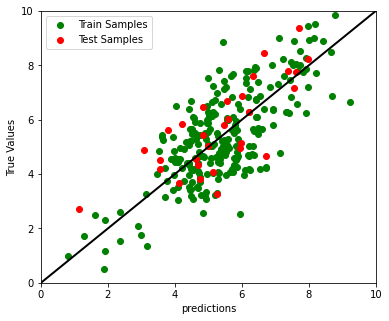

[0.03974125 0.09246866 0.08878925 0.15799394 0.03817097 0.05424675
 0.02573359 0.0224924  0.11746079 0.18306629 0.0916412  0.02792794
 0.06026698]


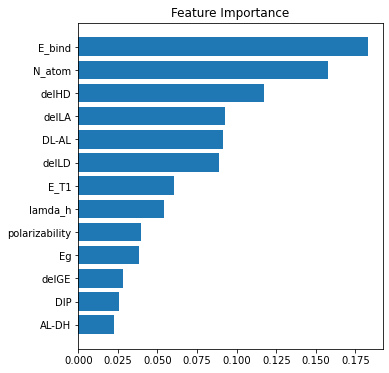

In [1]:
#DOI: 10.1002/aenm.201801032
import numpy as np
from numpy import genfromtxt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math

### Files ###
train = genfromtxt('./train.csv', delimiter=',')
test = genfromtxt('./test.csv', delimiter=',')

# functions
def PearsonCoefficient(X, Y):
    r=np.sum((X-np.average(X))*(Y-np.average(Y)))/math.sqrt(np.sum((X-np.average(X))**2)*np.sum((Y-np.average(Y))**2))
    return r
def RMSE(X,Y):
    rmse=math.sqrt(np.sum((Y-X)**2)/len(Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(X-Y)/Y)*100
    return mape

#data loader                                                                                                                                                                                                                                                  
traintestX=train[:,2:]
traintesty=train[:,1]
testX=test[:,2:]
testy=test[:,1] 
trainX=train[:,2:]
trainy=train[:,1]

#train
gbdt = GradientBoostingRegressor(n_estimators=250,random_state=3426,max_depth=3,learning_rate=0.10175921234852,min_samples_split=4,min_samples_leaf=2,max_features=7)
loo = LeaveOneOut()
y_exp_list,y_pred_list_GB=[],[]
for train_index, test_index in loo.split(traintestX):
    X_train, X_test = traintestX[train_index], traintestX[test_index]
    y_train, y_test = traintesty[train_index], traintesty[test_index]
    gbdt.fit(X_train,y_train)
    y_pred_GB=gbdt.predict(X_test)
    y_pred_list_GB.append(y_pred_GB)
    y_exp_list.append(y_test)
r_GB=np.corrcoef(np.array(y_pred_list_GB)[:,0],np.array(y_exp_list)[:,0])[0][1]
MAPE_GB=MAPE(np.array(y_pred_list_GB),np.array(y_exp_list))
RMSE_GB=RMSE(np.array(y_pred_list_GB),np.array(y_exp_list))
One_GB=np.array([MAPE_GB,RMSE_GB,r_GB])
print(One_GB)

#save result
trainresult = np.concatenate((y_pred_list_GB, y_exp_list), axis=0)
np.savetxt('./trainresult.csv',trainresult,fmt='%.3f',delimiter=',')

#test
gbdt.fit(trainX,trainy)
test_pred = gbdt.predict(testX)
MAPE_GB=MAPE(test_pred,testy)
RMSE_GB=RMSE(test_pred,testy)
r_GB=PearsonCoefficient(test_pred,testy)
test_GB=np.array([MAPE_GB,RMSE_GB,r_GB])
print(test_GB)

# 散点图
fig, ax = plt.subplots(figsize=(6, 5))
plt.axis([0, 10, 0, 10])
ax.scatter(y_pred_list_GB, y_exp_list, color="green", label="Train Samples")
ax.scatter(test_pred, testy, color="red", label="Test Samples")
line = mlines.Line2D([0, 1], [0, 1], color='black', linewidth=2)
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('predictions')
plt.ylabel('True Values')
plt.legend()
plt.show()

#save result
testresult = np.concatenate((testy, test_pred), axis=0)
np.savetxt('./testresult.csv',testresult,fmt='%.3f',delimiter=',')

# feature_importance
feature_importance = gbdt.feature_importances_
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
feature_names = ['polarizability', 'delLA', 'delLD', 'N_atom', 'Eg', 'lamda_h', 'DIP',
                 'AL-DH', 'delHD', 'E_bind', 'DL-AL', 'delGE', 'E_T1']
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance")
plt.show()